In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import math

In [2]:
def readTextFile(path):
  list_of_files =sorted(os.listdir("./FDDB/FDDB-folds/"))

  for index, file in enumerate(list_of_files):
    #READ ALL THE ANNOTATION FILE AND STOR IT IN ONE LIST
    if index % 2 == 0:
      with open(anontation_path+list_of_files[index]) as ff:
          for xx in ff: 
              ann.append(xx.rstrip())
    else:
      with open(anontation_path+list_of_files[index]) as f:
        for xx in f:
          all_image_path.append(xx.rstrip())

  return all_image_path,ann


def parseAnnotation(image_path,annotationList):
  faces=[]
  numOfFace=0
  image_Full_path= "./FDDB/originalPics/"+ image_path.strip()+".jpg"
  if image_path in annotationList:
    index=annotationList.index(image_path)

    numOfFace= int(annotationList[index+1])
    index=index+2
  for i in range(numOfFace):
     faces.append(annotationList[index].rstrip())
     index=index+1

  return  faces, numOfFace, image_Full_path


def check(value):
    if value < 0:
        value = 0
    return value

def checkratio(image1,image2):
    ratio=  image1.size/image2.size
    
    return ratio

def crop_face(image_path,faces,numberOfFaceInImage):
    '''
    this function take 
    
    image path: to read image
    faces : annotation of ellips 
    numberOfFaceInImage: number of face inside the image
                            to drow ellipce or exracted the face 
    return: the face image crop it from the image
            and left top right bottom of the image 
    '''
    img= cv2.imread(image_path)  
    crop_faces = []
    coord_crop_faces = []
    for i in range(numberOfFaceInImage):
        axis_radius1, axis_radius2, angle, center_x, center_y, _ = faces[i].split()
        axis_radius1= float(axis_radius1)
        axis_radius2= float(axis_radius2)
       
        
        major_axis = int(max(axis_radius1, axis_radius2))
        minor_axis = int(min(axis_radius1, axis_radius2))
        angle = int(math.degrees(float(angle))) 
        center_x, center_y = int(float(center_x)), int(float(center_y))
        
        temp_crop_face = img[check(center_y-major_axis):check(center_y+major_axis), check(center_x-minor_axis):check(center_x+minor_axis)]
        crop_faces.append(temp_crop_face)
        temp_coord_crop_face = check(center_x-minor_axis), check(center_y-major_axis), check(center_x+minor_axis), check(center_y+major_axis)
        coord_crop_faces.append(temp_coord_crop_face)
       
    return crop_faces, coord_crop_faces 



def drowElipse(image_path,faces,numberOfFaceInImage):
    
  img= cv2.imread(image_path)  
  for i in range(numberOfFaceInImage):
      axis_radius1, axis_radius2, angle, center_x, center_y, _ = faces[i].split()
      
      axis_radius1= float(axis_radius1)
      axis_radius2= float(axis_radius2)
      major_axis = int(max(axis_radius1, axis_radius2))
      minor_axis = int(min(axis_radius1, axis_radius2))
      angle = int(math.degrees(float(angle))) 
      center_x, center_y = int(float(center_x)), int(float(center_y))
      #draw the ellipse in the image
      cv2.ellipse(img, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, color=(0,0,255), thickness=3)
      
  plt.figure()
  plt.imshow(img)

def bb_intersection_over_union(boxA, boxB):
#-------determine the (x, y)-coordinates of the intersection rectangle---------
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
#-------compute the area of intersection rectangle--------------------------
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
#-------compute the area of both the prediction and ground-truth--------------
#-------rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
#------- compute the intersection over union by taking the intersection
#------- area and dividing it by the sum of prediction + ground-truth
#------- areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
#------- return the intersection over union value
	return iou


def generate_random_box(crop_faces, fullPath, numFace):
  '''
  Parameters
  ----------
  crop_faces : list
      contain the faces image.
  fullPath : sting
      path to the image in the datasest to read.
  numFace : int
      number of face in each image.    

  Returns
  -------
  boxb : list 
      contain [wl, wt, wr, wb] for random box
      as much as #faces in image 
  temp_backround : list
        list of backround crop from image
        as much as #faces in image.
  ratio : float
      ratio of the image size and face size
      help to decide if the face as big as image
      then even ignore the image or reduce the size of box to half
      to be able to extract the backround not overlap this face.

  '''
  boxb=[]
  allratio=[]
  temp_backround=[]
  image = cv2.imread(fullPath)
  
  for index in range(numFace):
      # print ("numofface ", numFace)
      # plt.figure()
      # plt.imshow(crop_faces[index])
      # ratio=  crop_faces[index].size/image.size
#----check if the size of face cover the big area of image
      ratio=checkratio(crop_faces[index],image)
      allratio.append(ratio)
      w_face= crop_faces[index].shape[1]
      h_face=crop_faces[index].shape[0]
      # print("w_face ,h_face",w_face ,h_face)
      # print(image.shape[1]-w_face)
      # print(image.shape[0]-h_face)

#------ to avoid fail of generate the random value for some images 
#-------which has the widht or hight of face equal to image width
      if (image.shape[1]-w_face<=0) or (image.shape[0]-h_face<=0):
          x = np.random.randint(image.shape[1]-w_face+1)
          y=np.random.randint(image.shape[0]-h_face+1)
      else:
          x = np.random.randint(image.shape[1]-w_face)
          y=np.random.randint(image.shape[0]-h_face)
          
      window=image[y:y+h_face,x:x+w_face]
      wl, wt, wr, wb = x,y,x+w_face,y+h_face
      backbox_dim=[wl, wt, wr, wb]
      # facebox_dim=coord_crop_faces[index]
      
      boxb.append(backbox_dim)
      temp_backround.append(window)
      # print("face shape",crop_faces[index].shape)
      # print ("window shape",window.shape)
      
      # plt.figure()
      # plt.imshow(window)
    
  return boxb,temp_backround,allratio
  
def extract_backround(crop_faces, coord_crop_faces, fullPath, numFace,imageIndex,ioucr=0.2,ratio=0.19):
    '''
    Parameters
    ----------
    crop_faces : list
        contain the faces`s image.
    coord_crop_faces : list 
        contain the (l,t,r,b) value of the box face.
    fullPath : string
        path to the image in the dataset to read.
    numFace : int
        number of face in each image.

    Returns
    -------
    list
        list with the backround image IOU with the face <0.2.

    '''
    crop_backround_list=[]
  

    # leastoverlap=[]
#---------still searching until we get as many backround as faces in the image
    while len(crop_backround_list)!= numFace:
        box,temp_back,ratio_list= generate_random_box(crop_faces, fullPath, numFace)
        # print (ratio_list)
#--------some images has one face cover all the image we exlcluded 
#---------image with more than 6 faces excluded as well
#--------- diffecult to extract backround without overlabing 
        if any(j>0.19 for j in ratio_list)or numFace>6:
            # with the same size of the face
            #print ("impossibel to get backround")
            global numimgexclude
            numimgexclude+=len(ratio_list)
            imgExcludelist.append(imageIndex)
            break
#--------check the overlaping between each box backround and each box face in the image
        for index, v in enumerate(box):
            for index1 , c in enumerate(coord_crop_faces):
                iou1=bb_intersection_over_union(c,v)
                # if iou1==0:
                    # leastoverlap.append((index,index1))
                iou.append(iou1)
#--------accept the group of backroud box satisfy the iou value
        if all(i<0.2 for i in iou ):
            # print (leastoverlap)
            # print (iou)
            crop_backround_list.append(temp_back)
        else:
            # print ("backround match with face not accept")
            # leastoverlap.clear()
            iou.clear()
            # temp_back.clear()
            
    return crop_backround_list

image I work on  0
image I work on  1
image I work on  2
image I work on  3
image I work on  4
image I work on  5
image I work on  6
image I work on  7
image I work on  8
image I work on  9
image I work on  10
image I work on  11
image I work on  12
image I work on  13
image I work on  14
image I work on  15
image I work on  16
image I work on  17
image I work on  18
image I work on  19
image I work on  20
image I work on  21
image I work on  22
image I work on  23
image I work on  24
image I work on  25
image I work on  26
image I work on  27
image I work on  28
image I work on  29
image I work on  30
image I work on  31
image I work on  32
image I work on  33
image I work on  34
image I work on  35
image I work on  36
image I work on  37
image I work on  38
image I work on  39
image I work on  40
image I work on  41
image I work on  42
image I work on  43
image I work on  44
image I work on  45
image I work on  46
image I work on  47
image I work on  48
image I work on  49
image I wo

image I work on  398
image I work on  399
image I work on  400
image I work on  401
image I work on  402
image I work on  403
image I work on  404
image I work on  405
image I work on  406
image I work on  407
image I work on  408
image I work on  409
image I work on  410
image I work on  411
image I work on  412
image I work on  413
image I work on  414
image I work on  415
image I work on  416
image I work on  417
image I work on  418
image I work on  419
image I work on  420
image I work on  421
image I work on  422
image I work on  423
image I work on  424
image I work on  425
image I work on  426
image I work on  427
image I work on  428
image I work on  429
image I work on  430
image I work on  431
image I work on  432
image I work on  433
image I work on  434
image I work on  435
image I work on  436
image I work on  437
image I work on  438
image I work on  439
image I work on  440
image I work on  441
image I work on  442
image I work on  443
image I work on  444
image I work 

image I work on  795
image I work on  796
image I work on  797
image I work on  798
image I work on  799
image I work on  800
image I work on  801
image I work on  802
image I work on  803
image I work on  804
image I work on  805
image I work on  806
image I work on  807
image I work on  808
image I work on  809
image I work on  810
image I work on  811
image I work on  812
image I work on  813
image I work on  814
image I work on  815
image I work on  816
image I work on  817
image I work on  818
image I work on  819
image I work on  820
image I work on  821
image I work on  822
image I work on  823
image I work on  824
image I work on  825
image I work on  826
image I work on  827
image I work on  828
image I work on  829
image I work on  830
image I work on  831
image I work on  832
image I work on  833
image I work on  834
image I work on  835
image I work on  836
image I work on  837
image I work on  838
image I work on  839
image I work on  840
image I work on  841
image I work 

image I work on  1182
image I work on  1183
image I work on  1184
image I work on  1185
image I work on  1186
image I work on  1187
image I work on  1188
image I work on  1189
image I work on  1190
image I work on  1191
image I work on  1192
image I work on  1193
image I work on  1194
image I work on  1195
image I work on  1196
image I work on  1197
image I work on  1198
image I work on  1199
image I work on  1200
image I work on  1201
image I work on  1202
image I work on  1203
image I work on  1204
image I work on  1205
image I work on  1206
image I work on  1207
image I work on  1208
image I work on  1209
image I work on  1210
image I work on  1211
image I work on  1212
image I work on  1213
image I work on  1214
image I work on  1215
image I work on  1216
image I work on  1217
image I work on  1218
image I work on  1219
image I work on  1220
image I work on  1221
image I work on  1222
image I work on  1223
image I work on  1224
image I work on  1225
image I work on  1226
image I wo

image I work on  1556
image I work on  1557
image I work on  1558
image I work on  1559
image I work on  1560
image I work on  1561
image I work on  1562
image I work on  1563
image I work on  1564
image I work on  1565
image I work on  1566
image I work on  1567
image I work on  1568
image I work on  1569
image I work on  1570
image I work on  1571
image I work on  1572
image I work on  1573
image I work on  1574
image I work on  1575
image I work on  1576
image I work on  1577
image I work on  1578
image I work on  1579
image I work on  1580
image I work on  1581
image I work on  1582
image I work on  1583
image I work on  1584
image I work on  1585
image I work on  1586
image I work on  1587
image I work on  1588
image I work on  1589
image I work on  1590
image I work on  1591
image I work on  1592
image I work on  1593
image I work on  1594
image I work on  1595
image I work on  1596
image I work on  1597
image I work on  1598
image I work on  1599
image I work on  1600
image I wo

image I work on  1936
image I work on  1937
image I work on  1938
image I work on  1939
image I work on  1940
image I work on  1941
image I work on  1942
image I work on  1943
image I work on  1944
image I work on  1945
image I work on  1946
image I work on  1947
image I work on  1948
image I work on  1949
image I work on  1950
image I work on  1951
image I work on  1952
image I work on  1953
image I work on  1954
image I work on  1955
image I work on  1956
image I work on  1957
image I work on  1958
image I work on  1959
image I work on  1960
image I work on  1961
image I work on  1962
image I work on  1963
image I work on  1964
image I work on  1965
image I work on  1966
image I work on  1967
image I work on  1968
image I work on  1969
image I work on  1970
image I work on  1971
image I work on  1972
image I work on  1973
image I work on  1974
image I work on  1975
image I work on  1976
image I work on  1977
image I work on  1978
image I work on  1979
image I work on  1980
image I wo

/home/tarek/anaconda3/envs/CVlab/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


#of ex 1268


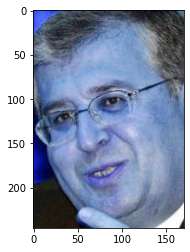

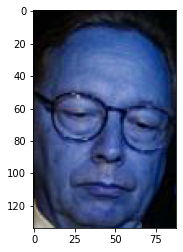

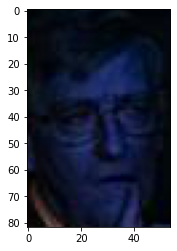

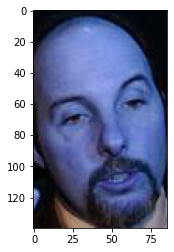

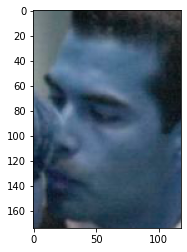

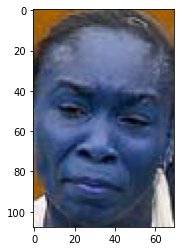

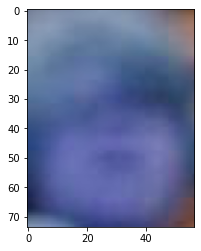

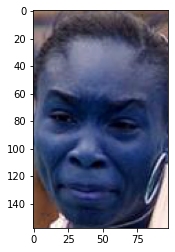

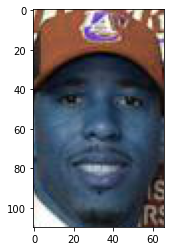

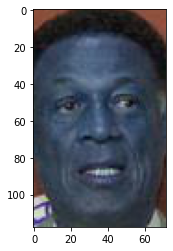

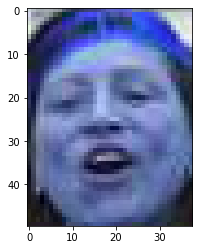

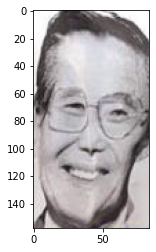

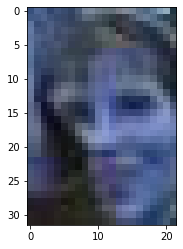

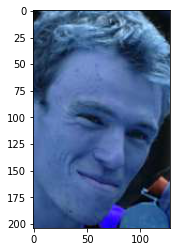

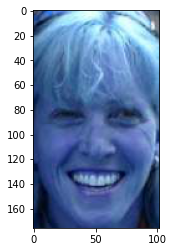

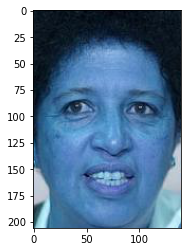

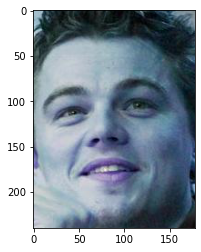

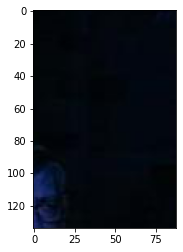

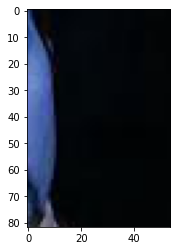

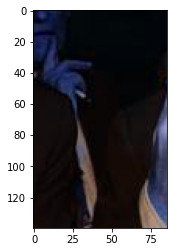

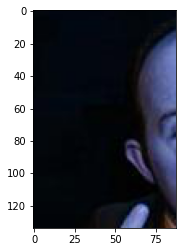

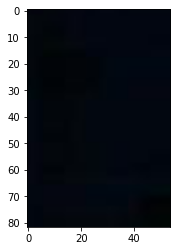

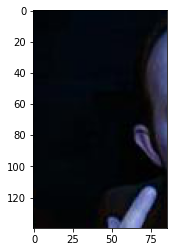

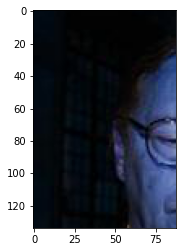

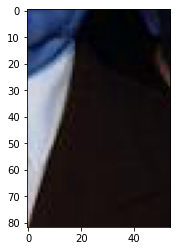

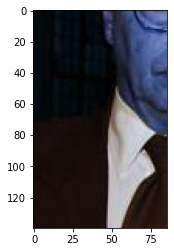

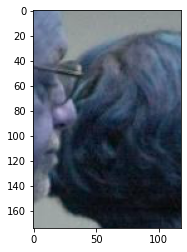

In [3]:
chdir="" 
ann= []
all_image_path=[]
fullPath=[]
directory_to_save_image='./faces'
boxa=[]
anontation_path = "./FDDB/FDDB-folds/"
iou=[]
numimgexclude=0 
allbackround=[]
allbackround2=[]
allfaces=[]
imgExcludelist=[]

#--------store the image name and annotation in tow different list-------------
image_path, ann= readTextFile(anontation_path)
choose_image_to_work_on=image_path

#--------for each image we extract the annotation and number of face------------
for index,path_list in enumerate(choose_image_to_work_on):
    print("image I work on ",index)
    faces, numFace,fullPath= parseAnnotation(path_list,ann)
    crop_faces, coord_crop_faces = crop_face(fullPath,faces,numFace)
    
#--------we append each face we find in image in "allfaces" list----------------
    allfaces.append(crop_faces)
#------- for image has many faces we return many group of backround
#-------- from the image satisfy the condition of IOU<0.2
#--------we stored all the backround
    back= extract_backround(crop_faces,coord_crop_faces,fullPath,numFace,index)
    if  len(back)==1:
        allbackround.append(back[0])
    elif len(back)==2:
        allbackround.append(back[0])
        allbackround.append(back[1])    
    elif len(back)==3:
        allbackround.append(back[0])
        allbackround.append(back[1])
        allbackround.append(back[2])
    elif len(back)==4:
        allbackround.append(back[0])
        allbackround.append(back[1])
        allbackround.append(back[2])
        allbackround.append(back[3])

#------instead of print the first 10 image you can save the image in new folder
print ("start saveing.... :")

for n , x in enumerate(allfaces[:10]):
    for b,img in enumerate(allfaces[n]):
        # print(n,x)
        filename = './faces/face{}{}.jpg'.format(n,b)
        # print(filename)
        plt.figure()
        plt.imshow(img)
        # cv2.imwrite(filename, img) 

#-------retrun as many backround as faces to save "4136"     
finalbackround = []
for n , x in enumerate(allbackround):
    for b,img in enumerate(allbackround[n]):
        if len(finalbackround)==4136:
            break
        else :
            finalbackround.append(img)
            
            
for index, img in enumerate(finalbackround[:10]):
    
    filename = './backround/back{}.jpg'.format(index)
    # print(filename)
    plt.figure()
    plt.imshow(img)
    # cv2.imwrite(filename, img) 
    
         
print("#of ex",numimgexclude)
        